# Trend and Technical Neural Network Weekly Stock Price Predictor

## Imports

In [1]:
#Initial Imports
import pandas as pd
from pathlib import Path
import numpy as np
import json
from datetime import date,datetime,timedelta
import os
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)
#!pip install yfinance 
#!pip install pytrends 

## Input Ticker

In [2]:
# Set Ticker of Interest
ticker = input()

 TSLA


## yFinance API Call and Technical Dataframe

In [3]:
def stock_data(ticker):
    start_date = '2017-04-10'
    end_date = date.today()+timedelta(days=1)
    
    # 1. Request data:
    data = yf.download(ticker, 
                      start=start_date, 
                      end=end_date,
                      interval='1wk', 
                      progress=False)
    
    # Time Series Variables Creation 

    # t+1, t-1, t-2, t-3 Volume
    data['Volume-1w'] = data['Volume'].shift(1)
    data['Volume-2w'] = data['Volume'].shift(2)
    data['Volume-3w'] = data['Volume'].shift(3)
    
    # t+1, t-1, t-2, t-3 Closes
    data['Close-1w'] = data['Close'].shift(1)
    data['Close-2w'] = data['Close'].shift(2)
    data['Close-3w'] = data['Close'].shift(3)

    # TARGET CREATION
    data['Next Week Close'] = data['Close'].shift(-1)
    
    # Reset Index
    data.reset_index(inplace=True)
    
    #data['Datetime']=data['Datetime'].dt.tz_convert('America/Montreal').dt.tz_localize(None)
    
    data.drop(['Adj Close', 'Open', 'High', 'Low'],axis=1,inplace=True)
    
    return data


<AxesSubplot:xlabel='date'>

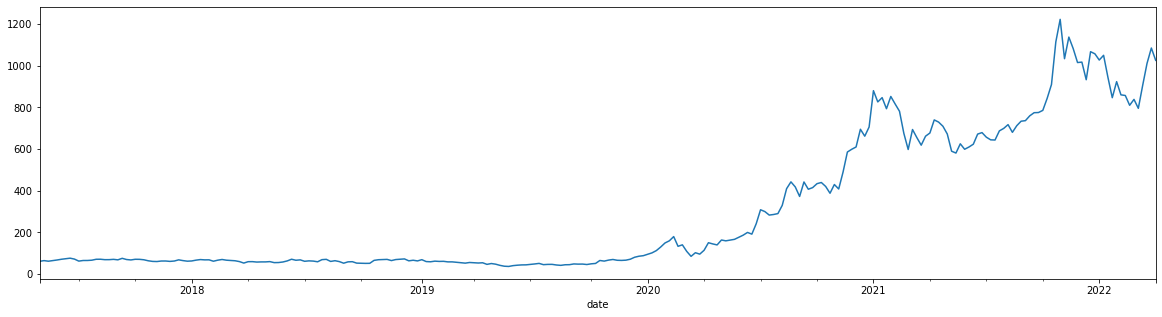

In [19]:
technical_analysis_df = pd.DataFrame(stock_data(ticker))
technical_analysis_df.set_index('Date', inplace = True)
technical_analysis_df = technical_analysis_df.dropna()
technical_analysis_df.index.rename('date', inplace = True)
technical_analysis_df.index = pd.to_datetime(technical_analysis_df.index)
technical_analysis_df["Close"].plot(figsize = (20,5))

## Tensorflow Model

In [5]:
# Initial imports

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [6]:
# Creating Featrues and Target
X = technical_analysis_df.iloc[:, [0,1,2,3,4,5,6,7]].values
y = technical_analysis_df["Next Week Close"].values

In [7]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [8]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1, 1)

In [9]:
# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler = StandardScaler().fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [10]:
# Define the model - shallow neural net
number_hidden_nodes = 30
hidden_nodes_layer2 = 30
number_input_features = 8

nn = Sequential()
# Hidden layer
nn.add(
    Dense(units=number_hidden_nodes, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(Dense(units=1, activation="linear"))

2022-04-09 09:18:32.958803: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Train the model
model_1 = nn.fit(X_train, y_train, epochs=500, shuffle=False, batch_size=10, verbose=1)

Epoch 1/500
18/18 [==============================] - 0s 878us/step - loss: 1.3043 - mse: 1.3043
Epoch 2/500
18/18 [==============================] - 0s 822us/step - loss: 0.8719 - mse: 0.8719
Epoch 3/500
18/18 [==============================] - 0s 866us/step - loss: 0.5859 - mse: 0.5859
Epoch 4/500
18/18 [==============================] - 0s 900us/step - loss: 0.3941 - mse: 0.3941
Epoch 5/500
18/18 [==============================] - 0s 875us/step - loss: 0.2593 - mse: 0.2593
Epoch 6/500
18/18 [==============================] - 0s 985us/step - loss: 0.1699 - mse: 0.1699
Epoch 7/500
18/18 [==============================] - 0s 821us/step - loss: 0.1149 - mse: 0.1149
Epoch 8/500
18/18 [==============================] - 0s 979us/step - loss: 0.0873 - mse: 0.0873
Epoch 9/500
18/18 [==============================] - 0s 824us/step - loss: 0.0733 - mse: 0.0733
Epoch 10/500
18/18 [==============================] - 0s 904us/step - loss: 0.0654 - mse: 0.0654
Epoch 11/500
18/18 [===================

## Plot the Loss

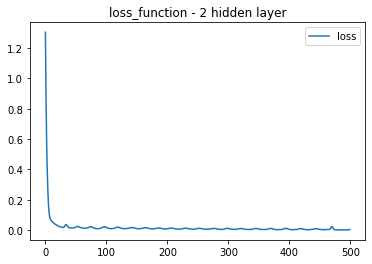

In [18]:
# Plot the train and test loss function
plt.plot(model_1.history["loss"])
plt.title("loss_function - 2 hidden layer")
plt.legend(["loss"])
plt.show()

## Evaluate the Model

In [13]:
nn.evaluate(X_test, y_test)

3/3 [==============================] - 0s 1ms/step - loss: 0.9633 - mse: 0.9633


[0.9633240103721619, 0.9633240103721619]

## Prediction Dataframe

In [14]:
# Make some predictions
predicted = nn.predict(X_test)

In [15]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [16]:
stocks = pd.DataFrame({ "Real": real_prices.ravel(),"Predicted": predicted_prices.ravel()}, index = technical_analysis_df.index[-len(real_prices): ])
stocks.tail()

,Real,Predicted
date,,
2022-03-07,905.390015,842.349487
2022-03-14,1010.640015,996.313904
2022-03-21,1084.589966,1027.246948
2022-03-28,1025.489990,1122.548340
2022-04-04,1025.489990,1087.571899


## Plot Predictions

<AxesSubplot:xlabel='date'>

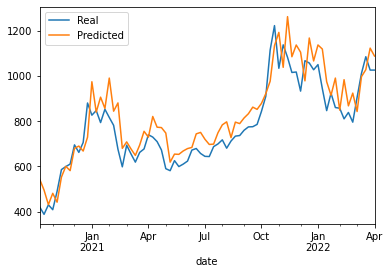

In [17]:
# Plot the real vs predicted prices as a line chart
stocks.plot()